## Getting Data Set Up

In [1]:
#Import packages 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import rioxarray
import geopandas as gpd
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from shapely.geometry import box
import cmocean
import verde as vd

In [2]:
import os
os.chdir('C:\\Users\\allyn\\Ice shelf research\\cryo_share')
print(os.getcwd())

C:\Users\allyn\Ice shelf research\cryo_share


In [3]:
gravity=pd.read_csv('gravity.csv')
bm = xr.open_dataset('bm.nc')

In [4]:
# Importing the moa image and trimming
moa = rioxarray.open_rasterio(Path('moa/geotiff/moa750_2014_hp1_v01.tif'))
moa_coast=gpd.read_file(Path('moa/coastlines/moa2014_coastline_v01.shp'))
moa_gl=gpd.read_file(Path('moa/coastlines/moa2014_grounding_line_v01.shp'))
moa_islands = gpd.read_file(Path('moa/coastlines/moa2014_islands_v01.shp'))

squeezed_moa = moa.squeeze('band')

xmin=-2250000
xmax=-1700000
ymin=300000
ymax=850000
x_trim = (moa.x > xmin) & (moa.x < xmax)
y_trim = (moa.y > ymin) & (moa.y < ymax)
moa_trim = moa.sel(x=x_trim, y=y_trim, band=1)

In [5]:
#Grounding Zone
grounding_zone = gpd.read_file(Path('Antarctic_GZ_2018_v01.0.shp'))
# reproject grounding zone from m to km
grounding_zone = grounding_zone.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

In [6]:
#Velocity Data
velocity_data = xr.open_dataset(Path('antarctic_ice_vel_phase_map_v01.nc'))

velocity_data=velocity_data.where(( xmin< velocity_data.x) & (velocity_data.x < xmax) 
                                  & (ymin < velocity_data.y) & (velocity_data.y < ymax), drop=True)

velocity_data = velocity_data.drop_vars(['coord_system'])

velocity_magnitude = np.sqrt(velocity_data['VX']**2 + velocity_data['VY']**2)

print(velocity_data.x[1]-velocity_data.x[0])

vd_coarsened=velocity_data.coarsen(x=50,y=50, boundary='pad').mean()

vd_coarsened['vmag']=np.sqrt(vd_coarsened['VX']**2 + vd_coarsened['VY']**2)

print(vd_coarsened.x[1]-vd_coarsened.x[0])

<xarray.DataArray 'x' ()> Size: 8B
array(450.)
<xarray.DataArray 'x' ()> Size: 8B
array(22500.)


In [7]:
# Getting rid of the 'band' dimension in the moa file and creating a location mask.
# Step 1: Select the first element of the 'band' dimension to eliminate it
moa_dropped = moa.isel(band=0)

# Step 2: Drop the 'band' coordinate if it exists
if 'band' in moa_dropped.coords:
    moa_dropped = moa_dropped.drop_vars('band')

print(moa_dropped.dims)

X,Y=np.meshgrid(moa.x,moa.y)

location_mask=((xmin<X) & (X<xmax)
               & (ymin<Y) & (Y<ymax))

('y', 'x')


# Getting to Know My Study Region Plot

In [8]:
bm['ice_shelves'] = ((bm.mask ==3).astype(int))
bach = bm.ice_shelves.where((-1920e3<bm.x) & (bm.x<-1810e3) & (530e3<bm.y) & (bm.y<670e3))
strange= bm.ice_shelves.where((-1900e3<bm.x) & (bm.x<xmax) & (330e3<bm.y) & (bm.y<480e3))

wilkins1=bm.ice_shelves.where((-2150e3<bm.x) & (bm.x<-1940e3) & (630e3<bm.y) & (bm.y<750e3))
wilkins2=bm.ice_shelves.where((-2070e3<bm.x) & (bm.x<-1980e3) & (570e3<bm.y) & (bm.y<630e3))
wilkins = np.where((wilkins1 == 1) ^ (wilkins2 == 1), 1, 0)

george1=bm.ice_shelves.where((-1810e3<bm.x) & (bm.x<xmax) & (480e3<bm.y) & (bm.y<ymax))
george2=bm.ice_shelves.where((-1940e3<bm.x) & (bm.x<-1810e3) & (670e3<bm.y) & (bm.y<ymax))
george3=bm.ice_shelves.where((xmin<bm.x) & (bm.x<-1940e3) & (750e3<bm.y) & (bm.y<ymax))
george6 = np.where((george1 == 1) ^ (george2 == 1) ^ (george3==1), 1, 0)

ice_shelves=np.where((george6 == 1) ^ (wilkins == 1) ^ (strange==1) ^(bach==1), 1, 0)
#bm['ice_shelves'] = xr.DataArray(ice_shelves, dims=['y', 'x'], coords={'x': bm.x.values, 'y': bm.y.values})

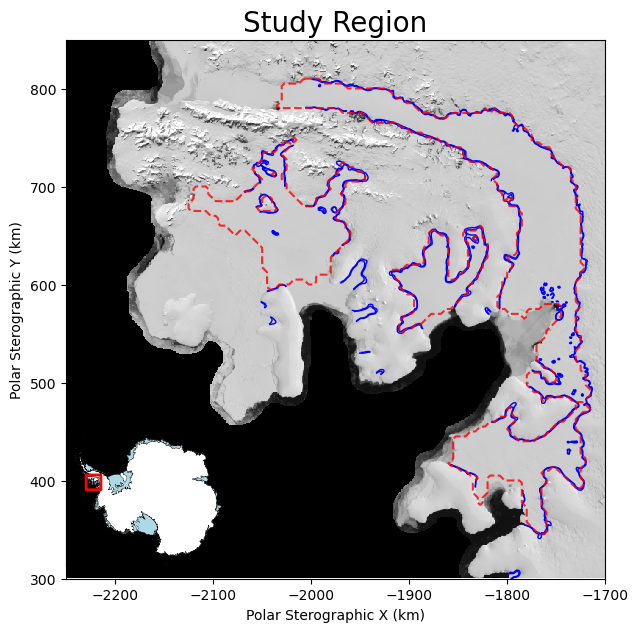

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.get_cmap('gray')
rgb = ls.shade(moa_trim.values, cmap=cmap, vert_exag=.1, blend_mode='soft', dx=5000, dy=5000)
# Plot the base data using pcolormesh
plt.pcolormesh(moa_trim.x / 1000, moa_trim.y / 1000, moa_trim, cmap='gray', vmin=0, vmax=20e3, shading='auto')

# Overlay the hillshade (already calculated in rgb)
plt.imshow(rgb, extent=[moa_trim.x.min() / 1000, moa_trim.x.max() / 1000, moa_trim.y.min() / 1000, moa_trim.y.max() / 1000],
           origin='lower', alpha=0.9)  # Adjust alpha to blend the hillshade


grounding_zone.plot(facecolor='none', edgecolor='blue', ax=ax, linewidth=1)

ax.contour(bm.x/1000, bm.y/1000, bach, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax.contour(bm.x/1000, bm.y/1000, strange, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax.contour(bm.x/1000, bm.y/1000, wilkins, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax.contour(bm.x/1000, bm.y/1000, george6, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)


plt.axis('scaled')
ax.set_title('Study Region', fontsize=20)
ax.set_xlim([xmin/1000, xmax/1000])
ax.set_ylim([ymin/1000, ymax/1000])
ax.set_xlabel('Polar Sterographic X (km)')
ax.set_ylabel('Polar Sterographic Y (km)')

ax_inset = ax.inset_axes([0, 0, 0.3, 0.3])  # [x, y, width, height] in relative coordinates via percentages
ax_inset.set_facecolor('black')
moa_coast.plot(facecolor='lightblue', edgecolor='k', ax=ax_inset, linewidth=0.2)
moa_gl.plot(facecolor='white', edgecolor='k', ax=ax_inset, linewidth=0.2)
moa_islands.plot(facecolor='white', edgecolor='k', ax=ax_inset, linewidth=0.2)
ax_inset.contour(moa.x, moa.y,location_mask, levels=[0.8], colors='red', linewidths=2)
ax_inset.axis('scaled')
ax_inset.set_xlim([-3e6, 3e6])
ax_inset.set_ylim([-2.5e6, 2.5e6])
ax_inset.set_yticks([])  
ax_inset.set_ylabel('') 
ax_inset.set_xticks([])  
ax_inset.set_xlabel('') 

plt.show()

# Velocity Plot

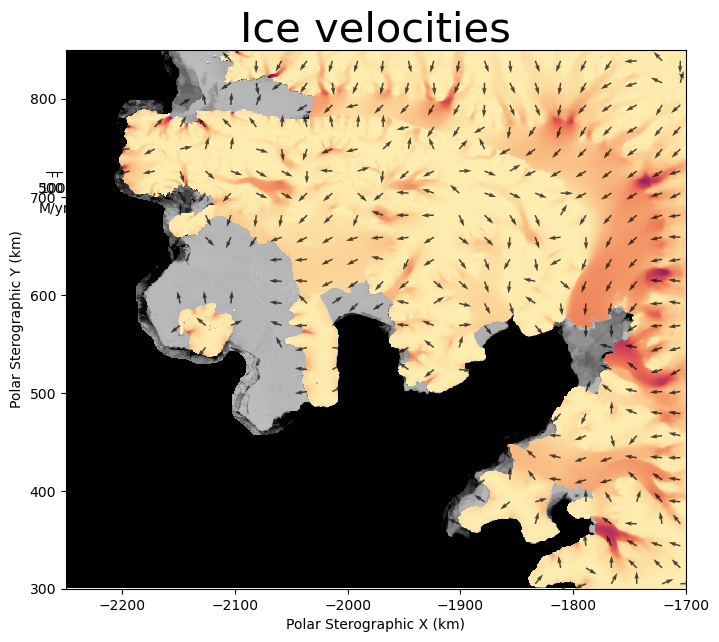

In [10]:
#Map Plot

fig, ax = plt.subplots(1, 1, figsize=(8,7))
map1= plt.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=6e3, vmax=20e3)

map2= plt.pcolormesh(velocity_data.x/1000, velocity_data.y/1000, velocity_magnitude, cmap='cmo.matter')

# Create the quiver plot
# Normalize the velocity vectors to get a unit vector for each arrow
VX_norm = vd_coarsened['VX'] / np.sqrt(vd_coarsened['VX']**2 + vd_coarsened['VY']**2)
VY_norm = vd_coarsened['VY'] / np.sqrt(vd_coarsened['VX']**2 + vd_coarsened['VY']**2)
#Plot the quiver plot
ax.quiver(vd_coarsened.x.values/1000, vd_coarsened.y.values/1000, 
                         VX_norm.values, VY_norm.values, 
                         scale=50, alpha=0.7)


#cbar = fig.colorbar(map2, ax=ax, label='Velocity (m/yr)', orientation='horizontal')
cbar_ax = fig.add_axes([0.1, 0.53, 0.02, 0.35])  # [left, bottom, width, height]
fig.colorbar(map2, cax=cbar_ax, label='M/yr', orientation='horizontal')

plt.axis('scaled')
ax.set_title('Ice velocities', fontsize=30)
ax.set_xlim([xmin/1000, xmax/1000])
ax.set_ylim([ymin/1000, ymax/1000])
ax.set_xlabel('Polar Sterographic X (km)')
ax.set_ylabel('Polar Sterographic Y (km)')

#Set colorbar up to be in lower left corner

plt.show()

# Sonar and Radar Coverage Figure

C:\Users\allyn\miniforge3\envs\cryo\lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


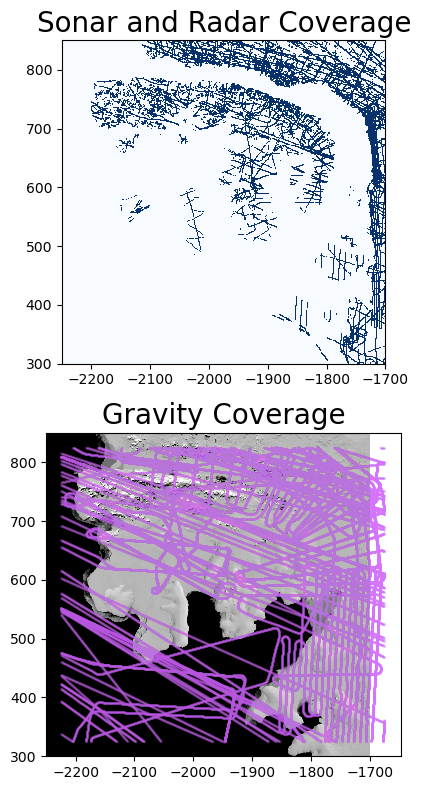

In [11]:
bm_full = xr.open_dataset('BedMachineAntarctica-v3.nc')
trimmed_bm_full = bm_full.where(( xmin< bm_full.x) & (bm_full.x < xmax) & (ymin < bm_full.y) & (bm_full.y < ymax), drop=True)
trimmed_bm_full = trimmed_bm_full.drop_vars(['mapping'])
coarsened_bm2=trimmed_bm_full.coarsen(x=3,y=3, boundary='pad').max().astype(int)

fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 8))
(ax1, ax2)= axes
bed_map= ax1.pcolormesh(coarsened_bm2.x/1000, coarsened_bm2.y/1000, coarsened_bm2.dataid>0, cmap='Blues')
ax1.set_title('Sonar and Radar Coverage', fontsize=20)
ax1.axis('scaled')

bed_map= ax2.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=6e3, vmax=20e3)
scatter = ax2.scatter(gravity.x/1000, gravity.y/1000, c='#d674fe', s=1, alpha=.03)
ax2.set_title('Gravity Coverage', fontsize=20)
ax2.axis('scaled')

plt.tight_layout()
plt.show()

# Gravity Coverage Figure

<function matplotlib.pyplot.show(close=None, block=None)>

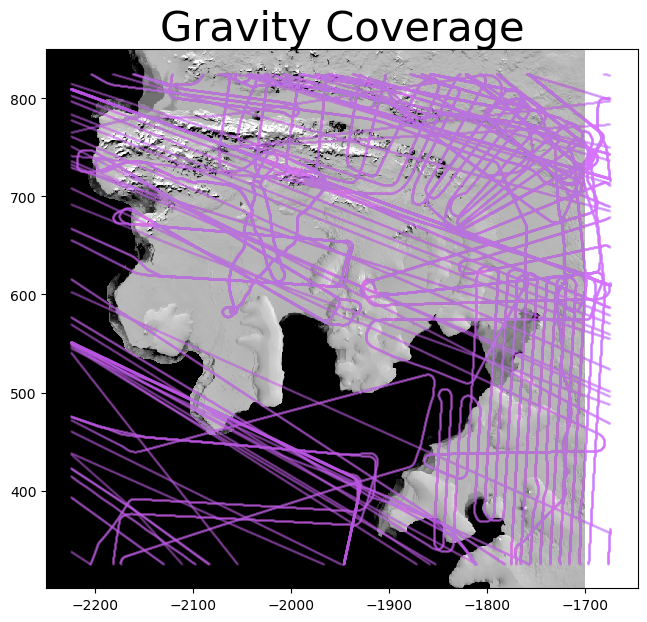

In [12]:
plt.figure(figsize=(8,7))
bed_map= plt.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=6e3, vmax=20e3)
scatter = plt.scatter(gravity.x/1000, gravity.y/1000, c='#d674fe', s=1, alpha=.03)
plt.title('Gravity Coverage', fontsize=30)
plt.axis('scaled')
plt.show

In [13]:
"""
How do you find/map the inversion domain and ice shelf?
You find  where the ice shelf is and data is gravity or interpolation
If gravity is when bm.source=6, according to bedmachine I don't have any data
Use a mask to mute are that isn't the ice shelf/ inversion domain or use a contour plot to show the border of the area
"""
spacing= bm.x[1]-bm.x[0]
print(spacing)
ice_shelves

<xarray.DataArray 'x' ()> Size: 4B
array(5000., dtype=float32)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### I am having a problem with my padded ice mask increasing size (can't map with bm.x/y)

In [14]:
custom_colors=['#5164e8', '#ffc780', '#ba580b', '#49e50f', '#e28f26']
custom_cmap = ListedColormap(custom_colors, name='my_custom_cmap')
"""
Dark blue = REMA/IBSCO
Light orange = Mass Consevation
Dark orange = Interpolation
Medium orange = Streamline Diffusion 
"""

'\nDark blue = REMA/IBSCO\nLight orange = Mass Consevation\nDark orange = Interpolation\nMedium orange = Streamline Diffusion \n'

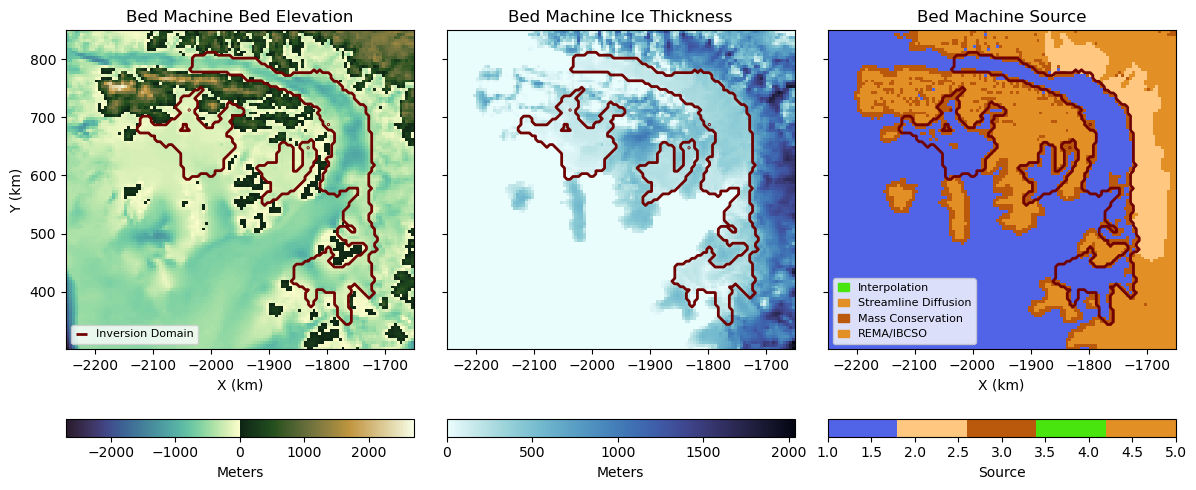

In [22]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
(ax1, ax2, ax3)= axes

#Bed
norm=plt.Normalize(vmin=-2700, vmax=2700)
cmap1=ax1.pcolormesh(bm.x/1000,bm.y/1000,bm.bed, cmap='cmo.topo', shading='auto', norm=norm)
fig.colorbar(cmap1, ax=ax1, orientation='horizontal', label= 'Meters')
cs=ax1.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='#700202', linewidths=2)
handles, _ = cs.legend_elements()
ax1.legend(handles, ['Inversion Domain'], loc='lower left',
          frameon=True, fontsize=8, handlelength=1, framealpha=0.8, facecolor='white')
ax1.set_title('Bed Machine Bed Elevation')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.axis('scaled')

#Thickness
cmap2=ax2.pcolormesh(bm.x/1000,bm.y/1000,bm.thickness, cmap='cmo.ice_r', shading='auto')
fig.colorbar(cmap2, ax=ax2,  orientation='horizontal', label= 'Meters')
ax2.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='#700202', linewidths=2)
ax2.set_title('Bed Machine Ice Thickness')
ax1.set_xlabel('X (km)')
ax2.axis('scaled')

#Source
cmap3=ax3.pcolormesh(bm.x/1000,bm.y/1000,bm.source, cmap=custom_cmap, shading='auto')
ax3.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='#700202', linewidths=2)
ax3.set_title('Bed Machine Source')
fig.colorbar(cmap3, ax=ax3,  orientation='horizontal', label= 'Source')
ax3.set_xlabel('X (km)')
ax3.axis('scaled')

dark_patch = mpatches.Patch(color=custom_cmap(3), label='Interpolation')
med_patch = mpatches.Patch(color=custom_cmap(4.5), label='Streamline Diffusion')
light_patch = mpatches.Patch(color=custom_cmap(2), label='Mass Conservation')
blue_patch = mpatches.Patch(color=custom_cmap(1.5), label='REMA/IBCSO')
plt.legend(handles=[dark_patch, med_patch, light_patch, blue_patch], facecolor='white',loc='lower left', fontsize=8, handlelength=1)


plt.tight_layout()
plt.savefig('BedMachine_Info.png', dpi=300, bbox_inches='tight')
plt.show()

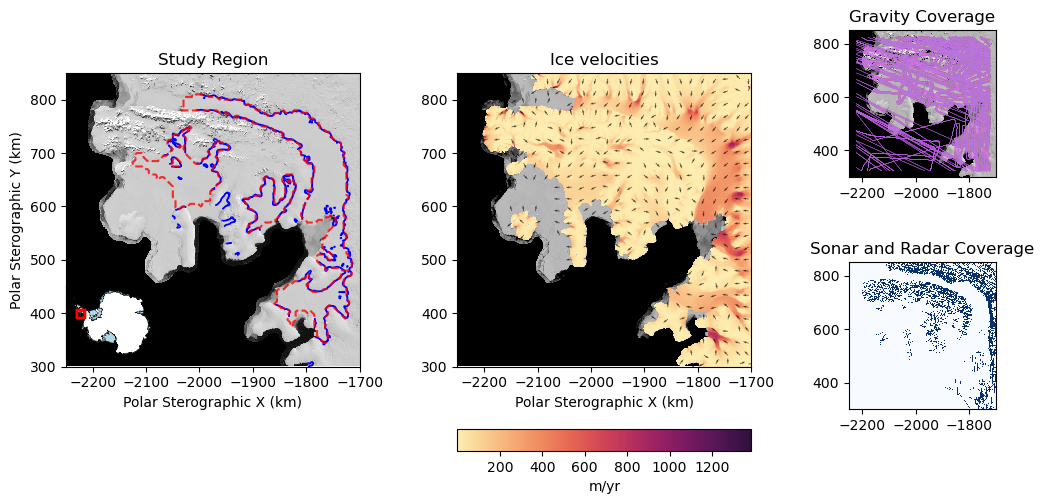

In [93]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, width_ratios=[1,1,0.5], figure=fig)

ax1 = fig.add_subplot(gs[:, 0])  #General plot
ax2 = fig.add_subplot(gs[:, 1]) # Velocity plot
ax3 = fig.add_subplot(gs[0, 2]) # Gravity coverage plot
ax4 = fig.add_subplot(gs[1, 2])  # Sonar and Radar plot

#General plot
bed_map= ax1.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=0, vmax=20e3)
grounding_zone.plot(facecolor='none', edgecolor='blue', ax=ax1, linewidth=1)
ax1.contour(bm.x/1000, bm.y/1000, bach, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax1.contour(bm.x/1000, bm.y/1000, strange, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax1.contour(bm.x/1000, bm.y/1000, wilkins, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax1.contour(bm.x/1000, bm.y/1000, george6, levels=[0.5], colors='red', linestyles='dashed', alpha=0.8)
ax1.axis('scaled')
ax1.set_title('Study Region')
ax1.set_xlim([xmin/1000, xmax/1000])
ax1.set_ylim([ymin/1000, ymax/1000])
ax1.set_xlabel('Polar Sterographic X (km)')
ax1.set_ylabel('Polar Sterographic Y (km)')
ax_inset = ax1.inset_axes([0, 0, 0.3, 0.3])  # [x, y, width, height] in relative coordinates via percentages
ax_inset.set_facecolor('black')
moa_coast.plot(facecolor='lightblue', edgecolor='k', ax=ax_inset, linewidth=0.2)
moa_gl.plot(facecolor='white', edgecolor='k', ax=ax_inset, linewidth=0.2)
moa_islands.plot(facecolor='white', edgecolor='k', ax=ax_inset, linewidth=0.2)
ax_inset.contour(moa.x, moa.y,location_mask, levels=[0.8], colors='red', linewidths=2)
ax_inset.axis('scaled')
ax_inset.set_xlim([-3e6, 3e6])
ax_inset.set_ylim([-2.5e6, 2.5e6])
ax_inset.set_yticks([])  
ax_inset.set_ylabel('') 
ax_inset.set_xticks([])  
ax_inset.set_xlabel('') 

#Velocity Plot
map1= ax2.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=6e3, vmax=20e3)
map2= ax2.pcolormesh(velocity_data.x/1000, velocity_data.y/1000, velocity_magnitude, cmap='cmo.matter')
# Create a separate GridSpec for the colorbar without disrupting others

gs_colorbar = GridSpec(3, 3, width_ratios=[1,1,0.5], height_ratios=[1,1,.1], figure=fig,)  # Adjust space for colorbar

# Add the colorbar next to the desired subplot (ax2)
cbar_ax = fig.add_subplot(gs_colorbar[2, 1])  # Colorbar on the right of ax2
fig.colorbar(map2, cax=cbar_ax, orientation='horizontal', label='m/yr')

# Create the quiver plot
# Normalize the velocity vectors to get a unit vector for each arrow
VX_norm = vd_coarsened['VX'] / np.sqrt(vd_coarsened['VX']**2 + vd_coarsened['VY']**2)
VY_norm = vd_coarsened['VY'] / np.sqrt(vd_coarsened['VX']**2 + vd_coarsened['VY']**2)
#Plot the quiver plot
ax2.quiver(vd_coarsened.x.values/1000, vd_coarsened.y.values/1000, 
                         VX_norm.values, VY_norm.values, 
                         scale=50, alpha=0.7)
#cbar = fig.colorbar(map2, ax=ax2, label='Velocity (m/yr)')
ax2.axis('scaled')
ax2.set_title('Ice velocities')
ax2.set_xlim([xmin/1000, xmax/1000])
ax2.set_ylim([ymin/1000, ymax/1000])
ax2.set_xlabel('Polar Sterographic X (km)')
ax2.set_ylabel('')

#Gravity Plot
bed_map1= ax3.pcolormesh(moa_trim.x/1000, moa_trim.y/1000, moa_trim, cmap='gray', vmin=6e3, vmax=20e3)
scatter = ax3.scatter(gravity.x/1000, gravity.y/1000, c='#d674fe', s=1, alpha=.03, linewidth=0.001)
ax3.set_title('Gravity Coverage')
ax3.axis('scaled')

#Sonar and Radar Plot
bed_map2= ax4.pcolormesh(coarsened_bm2.x/1000, coarsened_bm2.y/1000, coarsened_bm2.dataid>0, cmap='Blues')
ax4.set_title('Sonar and Radar Coverage')
ax4.axis('scaled')

plt.subplots_adjust(wspace=0.4, hspace=0.01)
plt.show()